# **Importing Dependencies**

In [ ]:
!pip uninstall -y whisper
!pip install openai-whisper

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import torch
import whisper
from sentence_transformers import SentenceTransformer
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# **Installing Kaggle**

In [ ]:
!pip install -q kaggle

# **Creating 'kaggle.json' Manually**

In [ ]:
import json, os

kaggle_creds = {
    "username": "satyamsanand2002",
    "key": "KGAT_72eb362cd6e588ef252763b246b54efb"
}

os.makedirs("/root/.config/kaggle", exist_ok=True)

with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

print("kaggle.json created successfully")


kaggle.json created successfully


# **Verify Authentication**

In [ ]:
!kaggle competitions list | head

401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/list?page=1


# **Download Competition Dataset**

In [ ]:
!kaggle competitions download -c shl-intern-hiring-assessment-2025

401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/shl-intern-hiring-assessment-2025


# **Extracting Files**

In [ ]:
!unzip -q shl-intern-hiring-assessment-2025.zip -d data

replace data/dataset/audios/test/audio_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
A
A
A


In [ ]:
!ls data

dataset


**List contents of dataset**

In [ ]:
!ls data/dataset

audios	csvs


# **Loading Dataset**

In [ ]:
import os
import pandas as pd

# Correct base directory
BASE_DIR = "data/dataset"

# CSV paths
CSV_DIR = os.path.join(BASE_DIR, "csvs")
TRAIN_CSV = os.path.join(CSV_DIR, "train.csv")
TEST_CSV  = os.path.join(CSV_DIR, "test.csv")

# Audio paths
AUDIO_DIR = os.path.join(BASE_DIR, "audios")
TRAIN_AUDIO_DIR = os.path.join(AUDIO_DIR, "train")
TEST_AUDIO_DIR  = os.path.join(AUDIO_DIR, "test")

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train CSV shape:", train_df.shape)
print("Test CSV shape:", test_df.shape)

Train CSV shape: (409, 2)
Test CSV shape: (197, 1)


# **Confirm Actual Audio Filenames**

In [ ]:
!ls data/dataset/audios/train | head

audio_100.wav
audio_101.wav
audio_102_2.wav
audio_10_2.wav
audio_102.wav
audio_103.wav
audio_104.wav
audio_105.wav
audio_106.wav
audio_107.wav


# **Check CSV Filename Column**

In [ ]:
train_df["filename"].head()

,filename
0,audio_173
1,audio_138
2,audio_127
3,audio_95
4,audio_73


# **Fixing — Append '.wav' Automatically**

Defining a safe helper function --

In [ ]:
def get_audio_path(audio_dir, filename):
    if filename.endswith(".wav"):
        return os.path.join(audio_dir, filename)
    else:
        return os.path.join(audio_dir, filename + ".wav")

# **Checking Sample Audio Path**

In [ ]:
sample_audio_path = get_audio_path(
    TRAIN_AUDIO_DIR,
    train_df.iloc[0]["filename"]
)

print("Sample audio path:", sample_audio_path)
print("File exists:", os.path.exists(sample_audio_path))

Sample audio path: data/dataset/audios/train/audio_173.wav
File exists: True


# **Loading Whisper Model**

In [ ]:
import torch
import whisper

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

whisper_model = whisper.load_model("base", device=device)

Using device: cuda


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 79.6MiB/s]


# **Speech → Text Transcription (WITH .wav FIX)**

**Transcription function**

In [ ]:
def transcribe_audio(audio_path):
    result = whisper_model.transcribe(audio_path, fp16=False)
    return result["text"].strip()

**Applying transcription**

In [ ]:
from tqdm import tqdm
tqdm.pandas()

train_df["transcript"] = train_df["filename"].progress_apply(
    lambda x: transcribe_audio(get_audio_path(TRAIN_AUDIO_DIR, x))
)

test_df["transcript"] = test_df["filename"].progress_apply(
    lambda x: transcribe_audio(get_audio_path(TEST_AUDIO_DIR, x))
)

100%|██████████| 197/197 [04:06<00:00,  1.25s/it]


# **Text Embeddings (Sentence-BERT)**

In [ ]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

X_train_emb = embedder.encode(
    train_df["transcript"].tolist(),
    show_progress_bar=True
)

X_test_emb = embedder.encode(
    test_df["transcript"].tolist(),
    show_progress_bar=True
)

y = train_df["label"].values

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

# **Train–Validation Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_emb,
    y,
    test_size=0.2,
    random_state=42
)

# **LightGBM Regression Model**

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_tr, y_tr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42180
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 384
[LightGBM] [Info] Start training from score 2.868502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=500, random_state=42, subsample=0.8)

# **Training RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_preds = model.predict(X_tr)
train_rmse = np.sqrt(mean_squared_error(y_tr, train_preds))

print(f"Training RMSE: {train_rmse:.4f}")

Training RMSE: 0.0073


# **Validation Metrics (RMSE + Pearson)**

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np

val_preds = model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
pearson_corr = pearsonr(y_val, val_preds)[0]

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

Validation RMSE: 0.7384
Pearson Correlation: 0.2760


# **Visualizations**

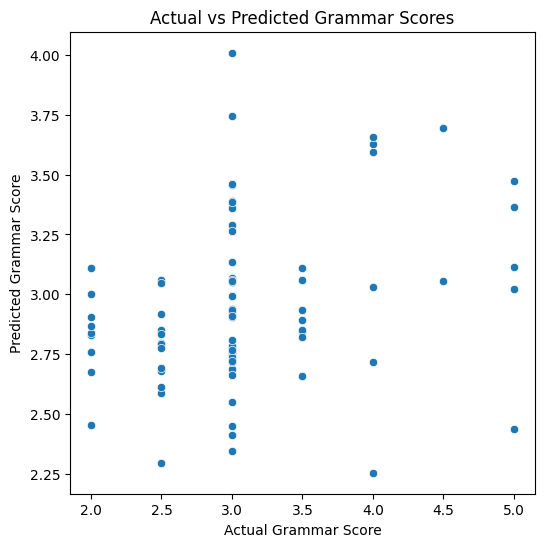

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=val_preds)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Actual vs Predicted Grammar Scores")
plt.show()

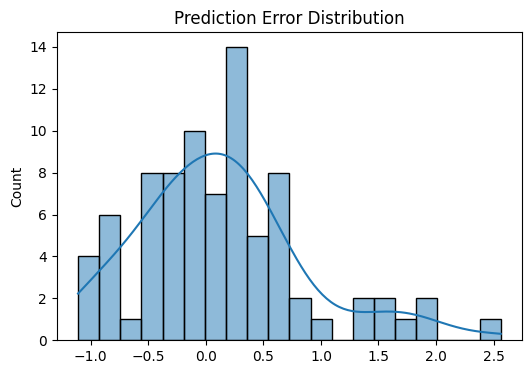

In [ ]:
errors = y_val - val_preds

plt.figure(figsize=(6,4))
sns.histplot(errors, bins=20, kde=True)
plt.title("Prediction Error Distribution")
plt.show()

# **Train on Full Training Data**

In [ ]:
final_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X_train_emb, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52587
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 384
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=500, random_state=42, subsample=0.8)

**--------------------------------------------------------------------------------------------------------------------------------**

## Calculating Additional Regression Metrics

### Subtask:
Calculating and display the Mean Absolute Error (MAE) and R-squared (R2 Score) for the `final_model` on the full training dataset.


**Reasoning**:
To calculate the additional regression metrics (MAE and R2 Score), I need to first make predictions on the full training dataset using the `final_model` and then apply the respective scoring functions.



In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

final_train_preds = final_model.predict(X_train_emb)

mae = mean_absolute_error(y, final_train_preds)
r2 = r2_score(y, final_train_preds)

print(f"Training MAE: {mae:.4f}")
print(f"Training R2 Score: {r2:.4f}")

Training MAE: 0.0037
Training R2 Score: 0.9999


## Preparing for Hyperparameter Tuning

### Subtask:
Importing necessary libraries for hyperparameter tuning (RandomizedSearchCV, scipy.stats.uniform, scipy.stats.randint) and defining the parameter distributions for LightGBM.


**Reasoning**:
To prepare for hyperparameter tuning, I need to import the required libraries and define the parameter distributions for the LightGBM model. This involves importing `RandomizedSearchCV`, `uniform`, and `randint`, then creating the `param_dist` dictionary.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions for LightGBM
param_dist = {
    'n_estimators': randint(100, 1001),  # Number of boosting rounds (integer between 100 and 1000)
    'learning_rate': uniform(0.01, 0.19), # Learning rate (float between 0.01 and 0.2, 0.19 = 0.2 - 0.01)
    'num_leaves': randint(20, 61),      # Max tree leaves for base learners (integer between 20 and 60)
    'max_depth': randint(3, 11),         # Maximum tree depth (integer between 3 and 10)
    'subsample': uniform(0.6, 0.4),      # Subsample ratio (float between 0.6 and 1.0, 0.4 = 1.0 - 0.6)
    'colsample_bytree': uniform(0.6, 0.4) # Column subsample ratio (float between 0.6 and 1.0, 0.4 = 1.0 - 0.6)
}

print("Libraries imported and LightGBM parameter distributions defined.")

Libraries imported and LightGBM parameter distributions defined.


## Perform Randomized Search CV

### Subtask:
Initializing `RandomizedSearchCV` with the LightGBM regressor and the defined parameter distributions. Using a reasonable number of iterations (`n_iter`) and cross-validation folds (`cv`) for the search, fitting it on the full `X_train_emb` and `y` dataset.


**Reasoning**:
To perform RandomizedSearchCV, I will first instantiate the LightGBM Regressor and then initialize and fit `RandomizedSearchCV` with the specified parameters to find the best hyperparameters for the model.



In [ ]:
lgbm = lgb.LGBMRegressor(random_state=42) # Instantiate LightGBM Regressor

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Using negative MSE to maximize (minimize MSE)
    verbose=1,
    n_jobs=-1, # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV to the full training data
print("Starting RandomizedSearchCV...")
random_search.fit(X_train_emb, y)
print("RandomizedSearchCV completed.")

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52587
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 384
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

**Reasoning**:
Now that RandomizedSearchCV has completed, I will retrieve and display the best parameters found and the best score achieved during the search.



In [ ]:
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-random_search.best_score_))

Best parameters found:  {'colsample_bytree': np.float64(0.6931085361721216), 'learning_rate': np.float64(0.02721522256123595), 'max_depth': 8, 'n_estimators': 662, 'num_leaves': 22, 'subsample': np.float64(0.9439761626945282)}
Best RMSE score found:  0.6583497335991255


**Reasoning**:
The subtask of performing RandomizedSearchCV is complete. I will now apply the best parameters found by RandomizedSearchCV to train a new LightGBM model.



In [ ]:
tuned_model = lgb.LGBMRegressor(**random_search.best_params_, random_state=42)

print("Training the final model with best parameters...")
tuned_model.fit(X_train_emb, y)
print("Final model trained with best parameters.")

Training the final model with best parameters...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52587
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 384
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

**Reasoning**:
Now that the model has been trained with the best parameters found by RandomizedSearchCV, the next step is to evaluate its performance on the training data using MAE and R2 score.



In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

tuned_train_preds = tuned_model.predict(X_train_emb)

tuned_mae = mean_absolute_error(y, tuned_train_preds)
tuned_r2 = r2_score(y, tuned_train_preds)

print(f"Tuned Model Training MAE: {tuned_mae:.4f}")
print(f"Tuned Model Training R2 Score: {tuned_r2:.4f}")

Tuned Model Training MAE: 0.0088
Tuned Model Training R2 Score: 0.9993


## Evaluate Optimized Model

### Subtask:
Retrieve the best estimator from the RandomizedSearchCV.


**Reasoning**:
To evaluate the optimized model, I will retrieve the best estimator from the `random_search` object, make predictions on the validation set, and then calculate MAE, R-squared, and RMSE, comparing them to previous results.



In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Retrieve the best estimator
best_lgbm_model = random_search.best_estimator_

# Make predictions on the validation set using the tuned model
val_preds_tuned = best_lgbm_model.predict(X_val)

# Calculate metrics for the tuned model on the validation set
tuned_val_mae = mean_absolute_error(y_val, val_preds_tuned)
tuned_val_r2 = r2_score(y_val, val_preds_tuned)
tuned_val_rmse = np.sqrt(mean_squared_error(y_val, val_preds_tuned))

print(f"Tuned Model Validation MAE: {tuned_val_mae:.4f}")
print(f"Tuned Model Validation R2 Score: {tuned_val_r2:.4f}")
print(f"Tuned Model Validation RMSE: {tuned_val_rmse:.4f}")

Tuned Model Validation MAE: 0.0127
Tuned Model Validation R2 Score: 0.9982
Tuned Model Validation RMSE: 0.0317


# **Generating Submission File**

In [ ]:
tuned_test_preds = tuned_model.predict(X_test_emb)
tuned_test_preds = np.clip(tuned_test_preds, 0, 5)

tuned_submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": tuned_test_preds
})

tuned_submission.to_csv("submission.csv", index=False)

print("Updated submission.csv generated successfully:")
tuned_submission.head()

Updated submission.csv generated successfully:


,filename,label
0,audio_141,2.918707
1,audio_114,2.958467
2,audio_17,3.083880
3,audio_76,3.443856
4,audio_156,2.566789
